<a href="https://colab.research.google.com/github/HoHoangHuyQuang/face_mask_recognition/blob/main/18067451_HoHoangHuyQuang_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Input: Ảnh có mặt người 

#### Output: 3 lớp Không đeo/ đeo đúng/ đeo sai

In [ ]:
import numpy as np  
import math                 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, SpatialDropout2D, Add, Dense, AveragePooling2D, Flatten, Input, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential, load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Load data

In [ ]:
import os
if not  os.path.exists('/content/FM_dataset/'):
  !unrar x   "/content/drive/MyDrive/FM_dataset.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/FM_dataset/val/face_with_mask_correct/002934.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002935.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002936.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002937.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002938.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002939.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002940.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002941.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002942.jpg      94%  OK 
Extracting  /content/FM_dataset/val/face_with_mask_correct/002943.jpg      94%  OK 
Extracting  /conten

In [ ]:
IMG_HEIGHT = 160
IMG_WIDTH = 160
INPUT_LAYER = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3) )
BATCH_SIZE = 64

In [ ]:
CLASSES_NAMES = dict()
CLASSES_NAMES[0] = "Face No Mask"
CLASSES_NAMES[1] = "Face With Mask Correct"
CLASSES_NAMES[2] = "Face With Mask Incorrect"

CLASSES_NAMES 

{0: 'Face No Mask', 1: 'Face With Mask Correct', 2: 'Face With Mask Incorrect'}

### Preprocessing Data Argument

In [ ]:
train_gen = ImageDataGenerator(rescale= 1.0/255,
                               rotation_range= 45.0,
                               horizontal_flip= True,                                
                               shear_range = 0.2,
                               zoom_range= 0.1,                               
                               dtype= 'float32',                               
                               )

train_data = train_gen.flow_from_directory('/content/FM_dataset/train',
                                        target_size= (IMG_HEIGHT, IMG_WIDTH),
                                        class_mode= 'categorical',
                                        batch_size = BATCH_SIZE,                                        
                                                                        
                                        )

Found 44019 images belonging to 3 classes.


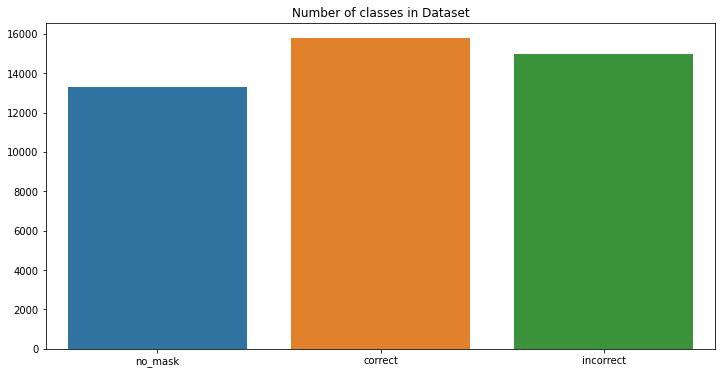

In [ ]:
import pandas as pd
import seaborn as sns
no_mask_dir = '/content/FM_dataset/train/face_no_mask'
correct_dir = '/content/FM_dataset/train/face_with_mask_correct'
incorrect_dir = '/content/FM_dataset/train/face_with_mask_incorrect'



num_no_mask = len(os.listdir(no_mask_dir))
num_correct = len(os.listdir(correct_dir ))
num_incorrect = len(os.listdir(incorrect_dir ))

df = pd.DataFrame(data = np.array([[num_no_mask, num_correct, num_incorrect ]]),columns=['no_mask', 'correct', 'incorrect'])
plt.figure(figsize=(12,6))
sns.barplot(data=df)
plt.title('Number of classes in Dataset')

In [ ]:
val_gen = ImageDataGenerator(rescale=1.0/255,
                              dtype='float32',                        
                             )

val_data = val_gen.flow_from_directory('/content/FM_dataset/val',
                                        target_size= (IMG_HEIGHT, IMG_WIDTH),
                                        class_mode= 'categorical',
                                        batch_size = BATCH_SIZE,
                                        
                                        )

Found 13197 images belonging to 3 classes.


In [ ]:
test_gen = ImageDataGenerator(rescale=1.0/255,
                              dtype='float32',                        
                             )

test_data = test_gen.flow_from_directory('/content/FM_dataset/test',
                                        target_size= (IMG_HEIGHT, IMG_WIDTH),
                                        class_mode= 'categorical',
                                        batch_size = BATCH_SIZE, 
                                        shuffle='False',                                                                             
                                        )

Found 8786 images belonging to 3 classes.


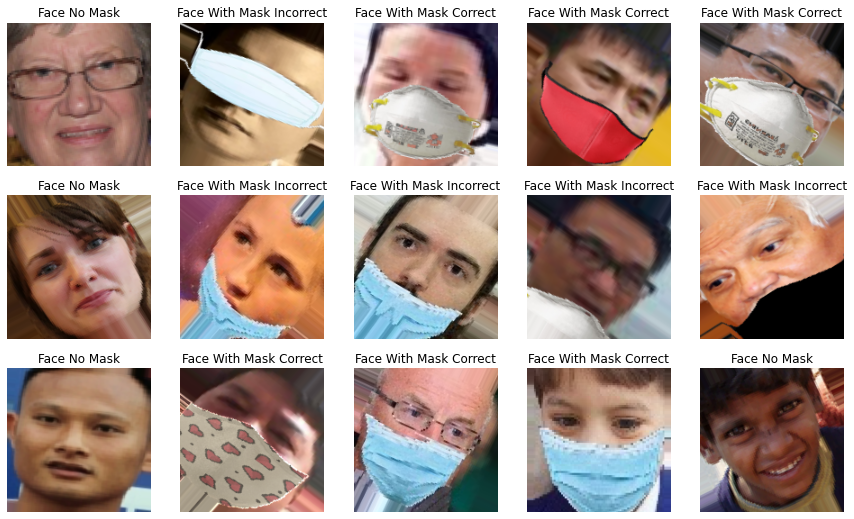

In [ ]:
def get_class(I_classes):
  _class = np.argmax(I_classes)
  return CLASSES_NAMES.get(_class)

def display_images(images, classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, image in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(get_class(classes[i] ))

images, classes = next(train_data)
display_images(images[:15], classes, cols=5)

In [ ]:
CALLBACKS = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience= 2, verbose= 1), # reduce learning rate
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience= 4, verbose= 1),  #early stop
    #tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/pre_train_models/{epoch:02d}.ckpt', save_weights_only=True, save_freq=3)
]

### Full connected model

Mạng Neural Network là sự kết hợp của những tầng perceptron hay còn gọi là perceptron đa tầng. Và mỗi một mạng Neural Network thường bao gồm 3 kiểu tầng là: 

Tầng input layer (tầng vào): Tầng này nằm bên trái cùng của mạng, thể hiện cho các đầu vào của mạng.

Tầng output layer (tầng ra): Là tầng bên phải cùng và nó thể hiện cho những đầu ra của mạng.

Tầng hidden layer (tầng ẩn): Tầng này nằm giữa tầng vào và tầng ra nó thể hiện cho quá trình suy luận logic của mạng. 

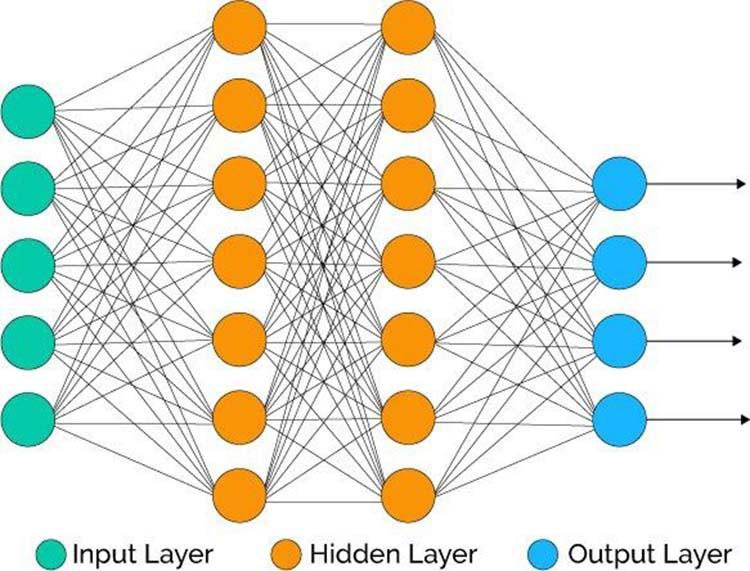

In [ ]:
def Fc_model(input_layer, dropout_rate=0.5, n_classes= 3):

  x = Flatten()(input_layer)
  x = Dense(512, activation='relu')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(256, activation ='relu')(x)
  x = Dropout(dropout_rate)(x)

  x = Dense(n_classes, activation='softmax')(x)
  model = Model(inputs= input_layer, outputs= x)
  return model

In [ ]:
model_1 = Fc_model(INPUT_LAYER)
model_1.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               39322112  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771   

In [ ]:
History_1 =  model_1.fit(train_data, 
                         epochs= 10,
                         validation_data = val_data,
                         callbacks= CALLBACKS
                         )

Epoch 1/10
542/542 [==============================] - 300s 553ms/step - loss: 2.7467 - accuracy: 0.3478 - val_loss: 1.0982 - val_accuracy: 0.3461
Epoch 2/10
542/542 [==============================] - 297s 548ms/step - loss: 1.1110 - accuracy: 0.3444 - val_loss: 1.0978 - val_accuracy: 0.3458
Epoch 3/10
542/542 [==============================] - 296s 547ms/step - loss: 1.0975 - accuracy: 0.3422 - val_loss: 1.0977 - val_accuracy: 0.3456
Epoch 4/10
542/542 [==============================] - 297s 548ms/step - loss: 1.0976 - accuracy: 0.3442 - val_loss: 1.0976 - val_accuracy: 0.3456
Epoch 5/10
542/542 [==============================] - 297s 548ms/step - loss: 1.0975 - accuracy: 0.3438 - val_loss: 1.0975 - val_accuracy: 0.3458
Epoch 6/10
542/542 [==============================] - 296s 547ms/step - loss: 1.0974 - accuracy: 0.3448 - val_loss: 1.0977 - val_accuracy: 0.3456
Epoch 7/10
542/542 [==============================] - 297s 549ms/step - loss: 1.0973 - accuracy: 0.3474 - val_loss: 1.0975 -

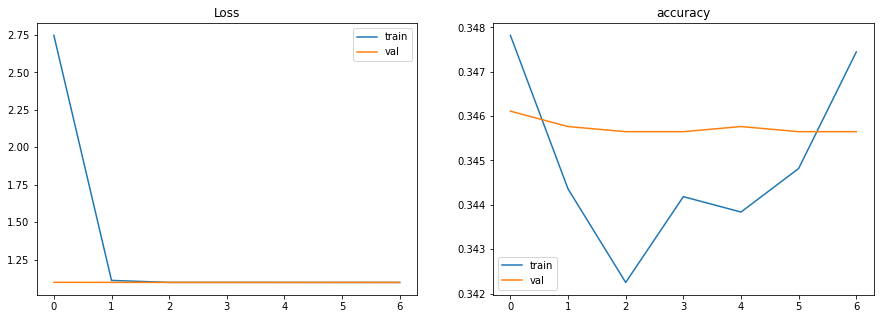

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History_1.history['loss'], label= 'train')
ax[0].plot(History_1.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History_1.history['accuracy'], label= 'train')
ax[1].plot(History_1.history['val_accuracy'], label= 'val')
ax[1].legend()

### CNN models

Trong mạng neural, mô hình mạng neural tích chập (CNN) là 1 trong những mô hình để nhận dạng và phân loại hình ảnh. 

CNN phân loại hình ảnh bằng cách lấy 1 hình ảnh đầu vào, xử lý và phân loại nó theo các hạng mục nhất định (Ví dụ: Chó, Mèo, Hổ, ...). Máy tính coi hình ảnh đầu vào là 1 mảng pixel và nó phụ thuộc vào độ phân giải của hình ảnh. Dựa trên độ phân giải hình ảnh, máy tính sẽ thấy H x W x D (H: Chiều cao, W: Chiều rộng, D: Độ dày)

CNN bao gồm những phần lớp cơ bản là: 

Convolutional layer
  \tCNN sử dụng các filter để áp dụng vào vùng của hình ảnh. Những filter map này được gọi là ma trận 3 chiều, mà bên trong nó là các con số và chúng là parameter. 

  Stride có nghĩa là khi bạn dịch chuyển filter map theo pixel dựa vào giá trị trừ trái sang phải. Và sự chuyển dịch này chính là Stride.

  Padding: Là các giá trị 0 được thêm vào với lớp input. 

  Feature map: Nó thể hiện kết quả của mỗi lần filter map quét qua input. Sau mỗi lần quét sẽ xảy ra quá trình tính toán. 

Relu layer là hàm kích hoạt trong neural network và hàm này còn được gọi là activation function

Pooling layer Khi đầu vào quá lớn, những lớp pooling layer sẽ được xếp vào giữa giữa những lớp Convolutional layer để làm giảm parameter. 

Fully connected layer Lớp này có nhiệm vụ đưa ra kết quả sau khi lớp convolutional layer và pooling layer

#### Model 2 CNN

In [ ]:
model_2 = Sequential()
model_2.add(INPUT_LAYER)
model_2.add(Conv2D(32, (7,7), activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(64, (7,7), activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(128, (7,7), activation='relu'))
model_2.add(MaxPooling2D())

model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(3, activation='softmax'))
model_2.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 154, 154, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        100416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       401536    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0

In [ ]:
History_2 =  model_2.fit(train_data, 
                         epochs= 5,
                         validation_data= val_data,
                         callbacks= CALLBACKS
                         )

Epoch 1/5
542/542 [==============================] - 354s 594ms/step - loss: 0.1823 - accuracy: 0.9309 - val_loss: 2.8146 - val_accuracy: 0.7780
Epoch 2/5
542/542 [==============================] - 319s 588ms/step - loss: 0.0775 - accuracy: 0.9752 - val_loss: 2.1881 - val_accuracy: 0.7617
Epoch 3/5
542/542 [==============================] - 320s 590ms/step - loss: 0.0742 - accuracy: 0.9769 - val_loss: 2.4768 - val_accuracy: 0.7787
Epoch 4/5
542/542 [==============================] - 320s 590ms/step - loss: 0.0508 - accuracy: 0.9844 - val_loss: 2.5119 - val_accuracy: 0.7962
Epoch 5/5
542/542 [==============================] - 318s 586ms/step - loss: 0.0581 - accuracy: 0.9826 - val_loss: 2.3096 - val_accuracy: 0.8039


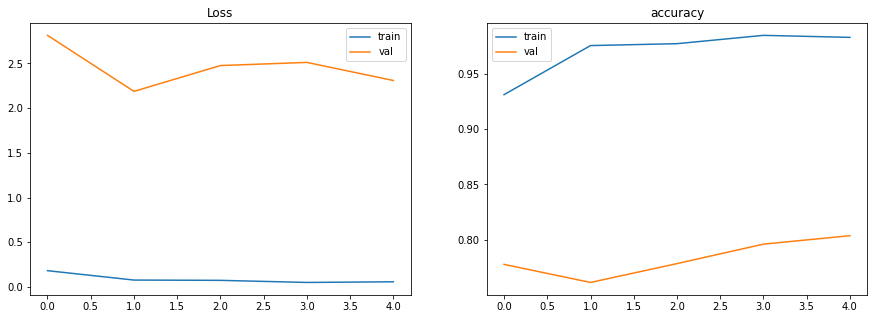

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History_2.history['loss'], label= 'train')
ax[0].plot(History_2.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History_2.history['accuracy'], label= 'train')
ax[1].plot(History_2.history['val_accuracy'], label= 'val')
ax[1].legend()

#### Model 3 CNN

In [ ]:
model_3 = Sequential()
model_3.add(INPUT_LAYER)
model_3.add(Conv2D(32, (5,5), kernel_initializer='he_normal',  activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(64, (5,5), kernel_initializer='he_normal',  activation='relu'))
model_3.add(MaxPooling2D())
model_3.add(Conv2D(128, (5,5), kernel_initializer='he_normal',  activation='relu'))
model_3.add(MaxPooling2D())

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(3, activation='softmax'))

model_3.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 156, 156, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0

In [ ]:
History_3 =  model_3.fit(train_data, 
                         epochs= 10,
                         validation_data = val_data,
                         callbacks= CALLBACKS
                         )

Epoch 1/10
542/542 [==============================] - 342s 570ms/step - loss: 0.2211 - accuracy: 0.9456 - val_loss: 3.4944 - val_accuracy: 0.7644
Epoch 2/10
542/542 [==============================] - 309s 570ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 3.9102 - val_accuracy: 0.7938
Epoch 3/10
542/542 [==============================] - 310s 571ms/step - loss: 0.0396 - accuracy: 0.9881 - val_loss: 1.2145 - val_accuracy: 0.8035
Epoch 4/10
542/542 [==============================] - 310s 571ms/step - loss: 0.0302 - accuracy: 0.9914 - val_loss: 3.7675 - val_accuracy: 0.7940
Epoch 5/10
542/542 [==============================] - 308s 569ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 6.1868 - val_accuracy: 0.8006
Epoch 6/10
542/542 [==============================] - 307s 567ms/step - loss: 0.0255 - accuracy: 0.9929 - val_loss: 2.2854 - val_accuracy: 0.8103
Epoch 7/10
542/542 [==============================] - 309s 570ms/step - loss: 0.0260 - accuracy: 0.9928 - val_loss: 2.6736 -

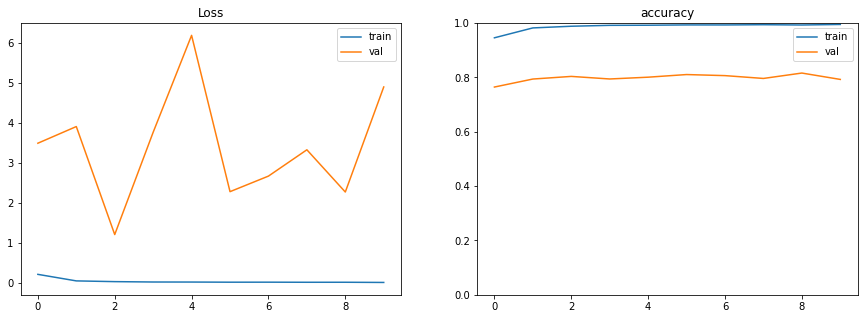

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History_3.history['loss'], label= 'train')
ax[0].plot(History_3.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History_3.history['accuracy'], label= 'train')
ax[1].plot(History_3.history['val_accuracy'], label= 'val')
ax[1].legend()
ax[1].set_ylim([0,1])
plt.show()

#### Model 4 CNN

In [ ]:
model_4 = Sequential()
model_4.add(INPUT_LAYER)
model_4.add(Conv2D(32, (3,3), kernel_initializer= 'he_normal', activation='relu', padding= 'same'))
model_4.add(Conv2D(32, (3,3), kernel_initializer='he_normal',  activation='relu', padding= 'same'))
model_4.add(MaxPooling2D())
model_4.add(Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_4.add(Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_4.add(MaxPooling2D())
model_4.add(Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_4.add(Conv2D(128, (3,3), kernel_initializer='he_normal',  activation='relu', padding= 'same'))
model_4.add(MaxPooling2D())

model_4.add(Flatten())
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(3, activation='softmax'))

model_4.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 128)       7

In [ ]:
History_4 =  model_4.fit(train_data, 
                         epochs= 10,
                         validation_data = val_data,
                         callbacks= CALLBACKS
                         )

Epoch 1/10
542/542 [==============================] - 366s 609ms/step - loss: 0.2138 - accuracy: 0.9367 - val_loss: 1.2643 - val_accuracy: 0.7959
Epoch 2/10
542/542 [==============================] - 325s 600ms/step - loss: 0.0680 - accuracy: 0.9790 - val_loss: 0.5568 - val_accuracy: 0.8426
Epoch 3/10
542/542 [==============================] - 332s 612ms/step - loss: 0.0425 - accuracy: 0.9872 - val_loss: 1.2265 - val_accuracy: 0.8036
Epoch 4/10
542/542 [==============================] - 332s 613ms/step - loss: 0.0401 - accuracy: 0.9881 - val_loss: 1.0978 - val_accuracy: 0.8340
Epoch 5/10
542/542 [==============================] - 334s 616ms/step - loss: 0.0358 - accuracy: 0.9902 - val_loss: 0.2055 - val_accuracy: 0.9315
Epoch 6/10
542/542 [==============================] - 334s 616ms/step - loss: 0.0492 - accuracy: 0.9852 - val_loss: 0.9685 - val_accuracy: 0.8384
Epoch 7/10
542/542 [==============================] - 333s 614ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 1.2308 -

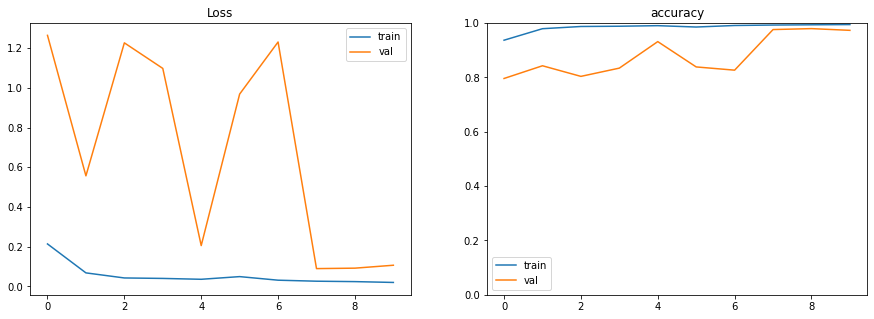

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History_4.history['loss'], label= 'train')
ax[0].plot(History_4.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History_4.history['accuracy'], label= 'train')
ax[1].plot(History_4.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0,1])
ax[1].legend()

In [ ]:
model_4.evaluate(test_data)

209/209 [==============================] - 24s 113ms/step - loss: 0.1198 - accuracy: 0.9609


[0.11980422586202621, 0.9608679413795471]

#### Model 5 CNN

In [ ]:
model_5 = Sequential()
model_5.add(INPUT_LAYER)
model_5.add(Conv2D(32, (3,3), kernel_initializer='he_normal',  activation='relu', padding= 'same'))
model_5.add(Conv2D(32, (3,3), kernel_initializer='he_normal',  activation='relu', padding= 'same'))
model_5.add(Dropout(0.2))
model_5.add(MaxPooling2D())

model_5.add(Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_5.add(Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_5.add(Dropout(0.2))
model_5.add(MaxPooling2D())

model_5.add(Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_5.add(Conv2D(128, (3,3), kernel_initializer='he_normal',  activation='relu', padding= 'same'))
model_5.add(Dropout(0.2))
model_5.add(MaxPooling2D())

model_5.add(Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu', padding= 'same'))
model_5.add(Conv2D(256, (3,3), kernel_initializer='he_normal',  activation='relu', padding= 'same'))
model_5.add(Dropout(0.2))
model_5.add(MaxPooling2D())

model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(3, activation='softmax'))

model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 160, 160, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 80, 64)        0

In [ ]:
History_5 =  model_5.fit(train_data, 
                         epochs= 20,
                         validation_data = val_data,
                         callbacks= CALLBACKS
                         )

Epoch 1/20
688/688 [==============================] - 428s 569ms/step - loss: 0.2525 - accuracy: 0.9206 - val_loss: 0.2023 - val_accuracy: 0.9245
Epoch 2/20
688/688 [==============================] - 386s 560ms/step - loss: 0.0762 - accuracy: 0.9770 - val_loss: 0.1693 - val_accuracy: 0.9318
Epoch 3/20
688/688 [==============================] - 383s 556ms/step - loss: 0.0607 - accuracy: 0.9820 - val_loss: 0.1929 - val_accuracy: 0.9229
Epoch 4/20
688/688 [==============================] - 384s 559ms/step - loss: 0.0466 - accuracy: 0.9868 - val_loss: 0.1648 - val_accuracy: 0.9493
Epoch 5/20
688/688 [==============================] - 384s 557ms/step - loss: 0.0380 - accuracy: 0.9898 - val_loss: 0.2216 - val_accuracy: 0.9253
Epoch 6/20
688/688 [==============================] - 385s 559ms/step - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.0863 - val_accuracy: 0.9733
Epoch 7/20
688/688 [==============================] - 382s 555ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.0592 -

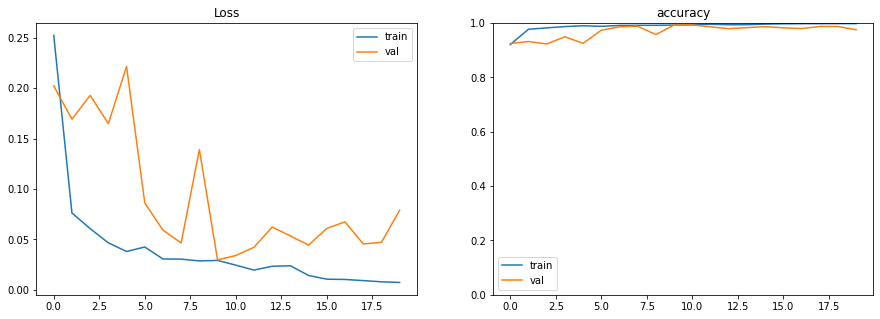

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History_5.history['loss'], label= 'train')
ax[0].plot(History_5.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History_5.history['accuracy'], label= 'train')
ax[1].plot(History_5.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0,1])
ax[1].legend()

In [ ]:
model_5.evaluate(test_data)

138/138 [==============================] - 20s 143ms/step - loss: 0.4022 - accuracy: 0.9067


[0.4022333323955536, 0.9066696763038635]

In [ ]:
model_5.save('/content/drive/MyDrive/pre_train_models/Cnn.h5')

### Model VGG16

VGG16 là mạng convolutional neural network được đề xuất bởi K. Simonyan and A. Zisserman, University of Oxford. Model sau khi train bởi mạng VGG16 đạt độ chính xác 92.7% top-5 test trong dữ liệu ImageNet gồm 14 triệu hình ảnh thuộc 1000 lớp khác nhau. Giờ áp dụng kiến thức ở trên để phân tích mạng VGG 16.

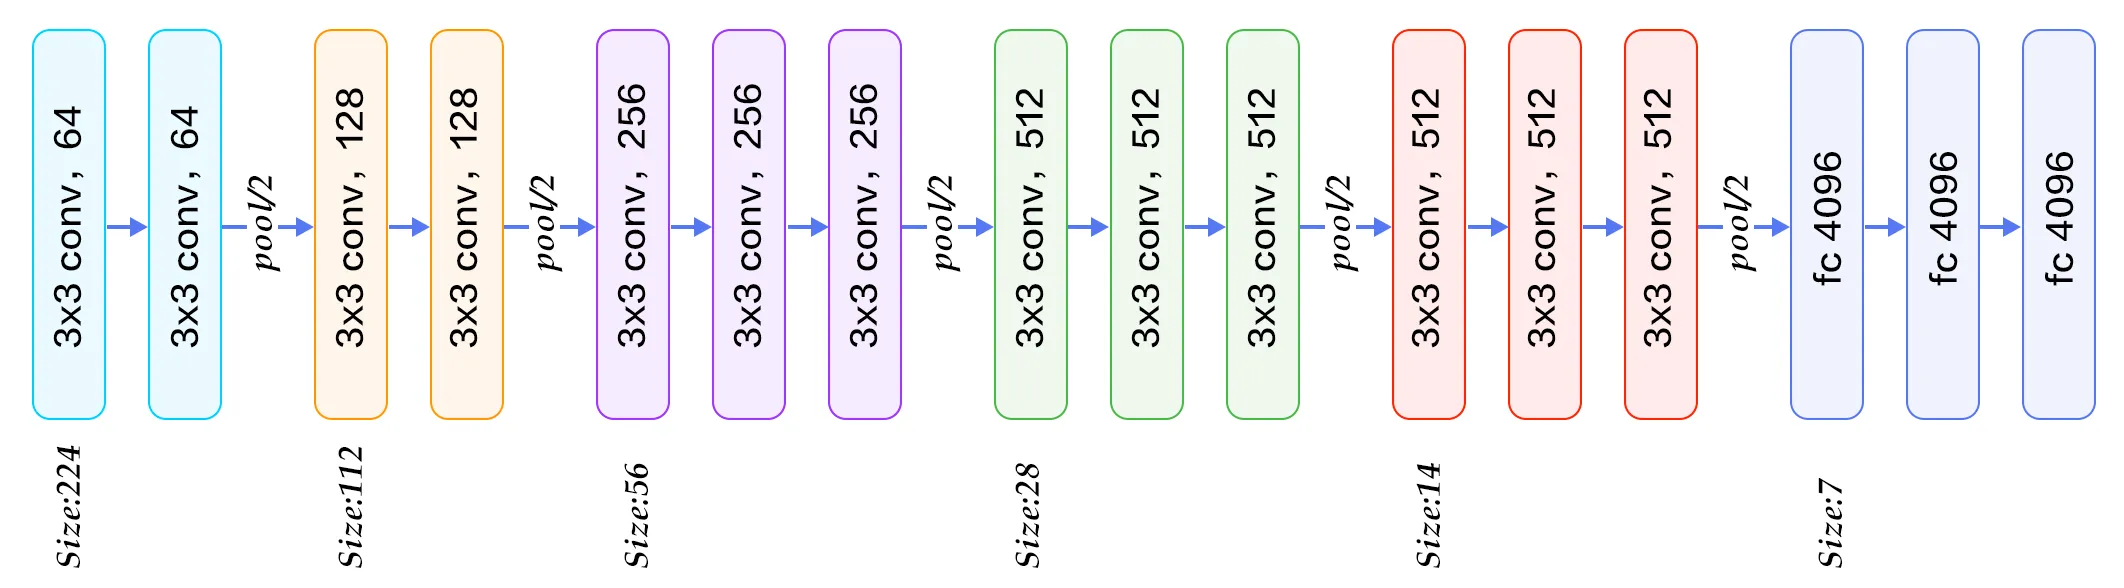

#### Vgg16 fine-tuning

In [ ]:
from tensorflow.keras.applications import VGG16
vgg_16_out = VGG16( include_top= False,
                weights="imagenet",
                input_shape= (160, 160, 3),
                pooling='avg')

vgg_16_out.trainable = True
set_train = False

for layer in vgg_16_out.layers:
  if layer.name == 'block5_conv1':
    set_train = True
  if set_train:
    layer.trainable= True
  else:
    layer.trainable = False

vgg_16_out.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [ ]:
from tensorflow.keras.applications import VGG16
vgg_16_out = VGG16( include_top= False,
                weights="imagenet",
                input_shape= (160, 160, 3),
                pooling='avg')

vgg_16_out.trainable = True
set_train = False

for layer in vgg_16_out.layers:
  if layer.name == 'block5_conv1':
    set_train = True
  if set_train:
    layer.trainable= True
  else:
    layer.trainable = False

vgg_16_out.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
History6 = model_vgg16.fit(train_data,
                epochs= 20,
                validation_data = val_data,
                callbacks= CALLBACKS
                    )

Epoch 1/20
688/688 [==============================] - 441s 624ms/step - loss: 0.0798 - accuracy: 0.9717 - val_loss: 0.3394 - val_accuracy: 0.9352
Epoch 2/20
688/688 [==============================] - 415s 604ms/step - loss: 0.0223 - accuracy: 0.9946 - val_loss: 0.4643 - val_accuracy: 0.9322
Epoch 3/20
688/688 [==============================] - 415s 603ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.1077 - val_accuracy: 0.9722
Epoch 4/20
688/688 [==============================] - 415s 603ms/step - loss: 0.0156 - accuracy: 0.9960 - val_loss: 0.0550 - val_accuracy: 0.9829
Epoch 5/20
688/688 [==============================] - 414s 601ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.0816 - val_accuracy: 0.9764
Epoch 6/20
688/688 [==============================] - 415s 603ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 0.3495 - val_accuracy: 0.9614
Epoch 7/20
688/688 [==============================] - 413s 600ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.0431 -

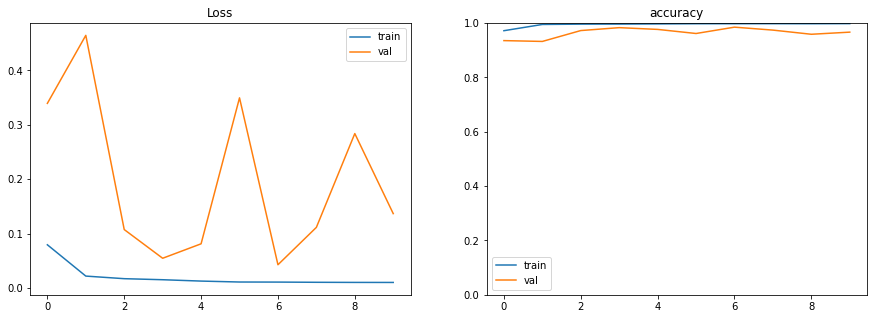

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History6.history['loss'], label= 'train')
ax[0].plot(History6.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History6.history['accuracy'], label= 'train')
ax[1].plot(History6.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0,1])
ax[1].legend()

#### VGG 16 self implement

In [ ]:
def VGG_16S(l2_reg = 0.0005, dropout_rate=0.2, n_classes= 3):
  input_layer = INPUT_LAYER
  x = Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_1_1')(input_layer)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_1_2')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2)(x)

  x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_2_1')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_2_2')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2)(x)

  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_3_1')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_3_2')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_3_3')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2)(x)

  x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_4_1')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_4_2')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_4_3')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=2)(x)

  x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_5_1')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_5_2')(x)
  x = BatchNormalization(axis=-1)(x)
  x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), activation='relu', name='conv_5_3')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size= 2)(x)

  flat = Flatten()(x)
  out = Dense(512, activation='relu')(flat)
  out = Dropout(dropout_rate)(out)
  out = Dense(128, activation='relu')(out)
  out = Dropout(dropout_rate)(out)
  out = Dense(n_classes, activation='softmax')(out)

  model = Model(inputs = input_layer, outputs= out)
  return model

In [ ]:
model_7 = VGG_16S()
model_7.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_7.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv_1_1 (Conv2D)            (None, 160, 160, 32)      896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 160, 160, 32)      128       
_________________________________________________________________
conv_1_2 (Conv2D)            (None, 160, 160, 32)      9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2_1 (Conv2D)            (None, 80, 80, 64)        1849

In [ ]:
History7 = model_7.fit(train_data,
                    epochs= 20,
                    validation_data = val_data,
                    callbacks= CALLBACKS
                    )


Epoch 1/20
688/688 [==============================] - 412s 595ms/step - loss: 2.0136 - accuracy: 0.9506 - val_loss: 1.3740 - val_accuracy: 0.9779
Epoch 2/20
688/688 [==============================] - 412s 599ms/step - loss: 0.9684 - accuracy: 0.9836 - val_loss: 1.0374 - val_accuracy: 0.8988
Epoch 3/20
688/688 [==============================] - 414s 601ms/step - loss: 0.5112 - accuracy: 0.9811 - val_loss: 0.4832 - val_accuracy: 0.9683
Epoch 4/20
688/688 [==============================] - 414s 601ms/step - loss: 0.3230 - accuracy: 0.9828 - val_loss: 0.4490 - val_accuracy: 0.9406
Epoch 5/20
688/688 [==============================] - 415s 603ms/step - loss: 0.2463 - accuracy: 0.9821 - val_loss: 0.2958 - val_accuracy: 0.9512
Epoch 6/20
688/688 [==============================] - 414s 601ms/step - loss: 0.2219 - accuracy: 0.9808 - val_loss: 0.1996 - val_accuracy: 0.9861
Epoch 7/20
688/688 [==============================] - 416s 605ms/step - loss: 0.2017 - accuracy: 0.9813 - val_loss: 0.5315 -

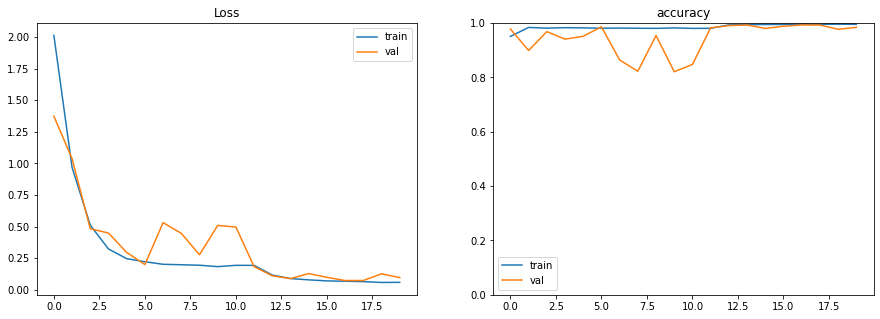

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History7.history['loss'], label= 'train')
ax[0].plot(History7.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History7.history['accuracy'], label= 'train')
ax[1].plot(History7.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0,1])
ax[1].legend()

### Inception v3 fine tuning

Inception (GoogleLeNet)
Vào năm 2014, các nhà nghiên cứu của google đã đưa ra mạng Inception 

Mô hình này khá đặc biệt, không hoàn toàn là các tầng layer nối tiếp gối đầu lên nhau như các mạng trên. Mạng gồm các đơn vị gọi là “inception cell” (cái này mình nghĩ không nên dịch) - thực hiện convolution 1 input với nhiều filter khác nhau rồi tổng hợp lại, theo nhiều nhánh (branch).

Để tiết kiệm tính toán, các convolution kích thước 1x1 được sử dụng để giảm chiều sâu chanel của input (reduce the input channel depth). Với mỗi 1 cell, sử dụng các 1x1, 3x3, 5x5 filter để extract các feature từ input.

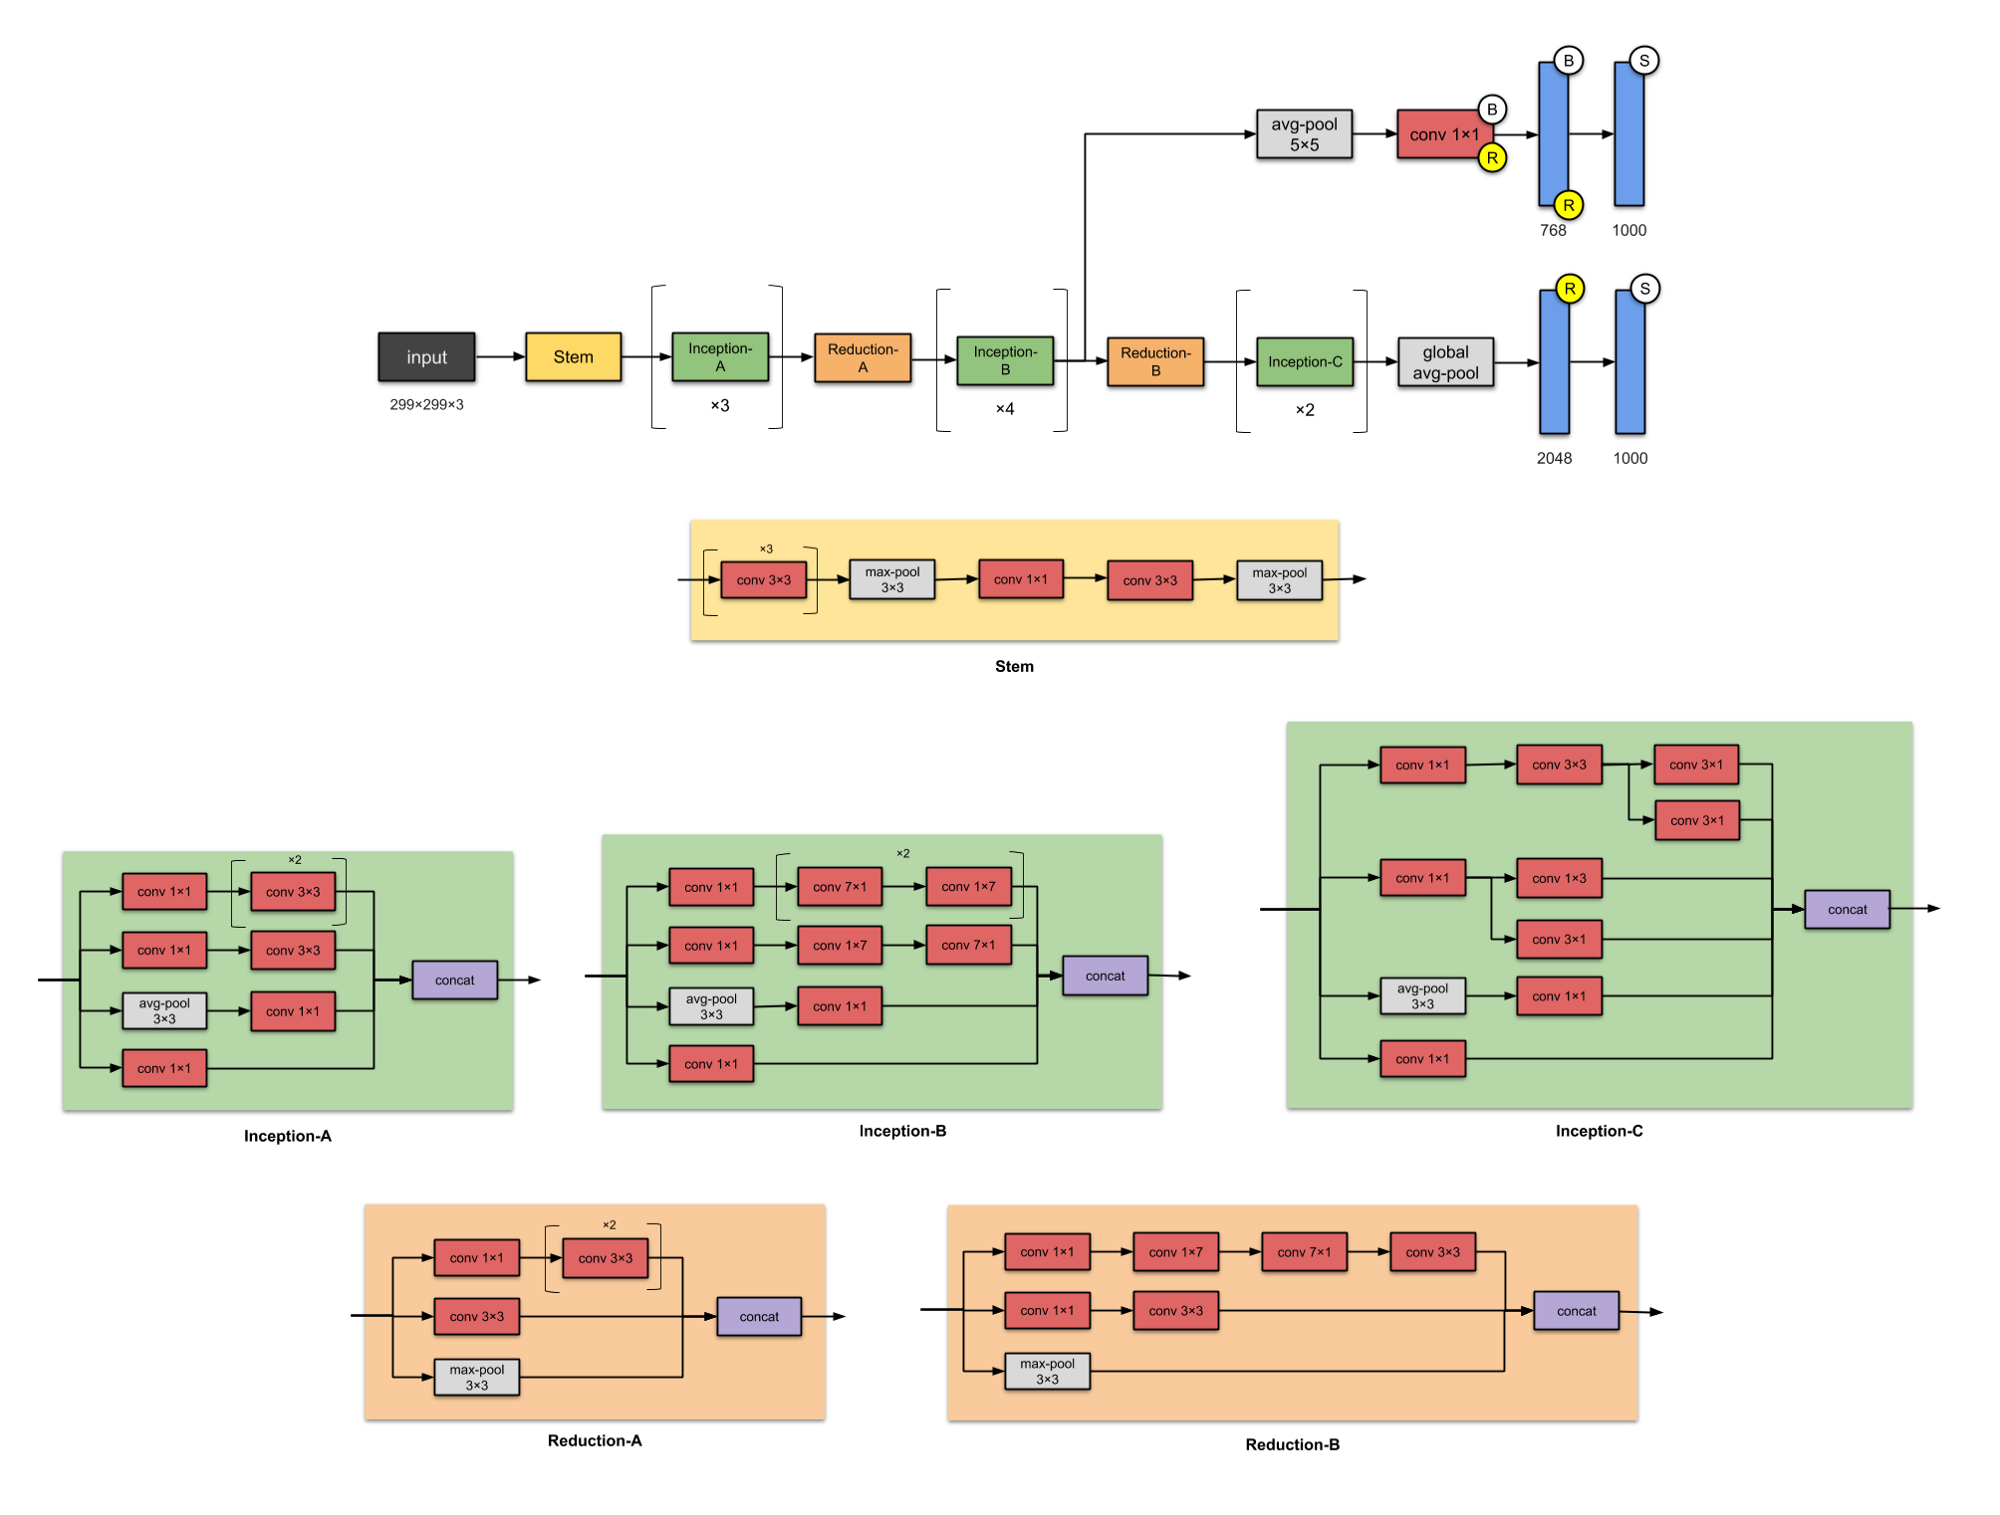

In [ ]:
inception_v3 = tf.keras.applications.InceptionV3(
              include_top=False,
              weights="imagenet",
              input_shape=(160, 160, 3),
              pooling='avg',
)

In [ ]:
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_337 (Conv2D)             (None, 79, 79, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_337 (BatchN (None, 79, 79, 32)   96          conv2d_337[0][0]                 
__________________________________________________________________________________________________
activation_337 (Activation)     (None, 79, 79, 32)   0           batch_normalization_337[0][0]    
_______________________________________________________________________________________

In [ ]:
History = inception_model.fit(train_data,
                    epochs= 20,
                    validation_data= val_data,
                    callbacks= CALLBACKS)

Epoch 1/20
688/688 [==============================] - 493s 705ms/step - loss: 0.0991 - accuracy: 0.9694 - val_loss: 0.6304 - val_accuracy: 0.7784
Epoch 2/20
688/688 [==============================] - 481s 698ms/step - loss: 0.0342 - accuracy: 0.9913 - val_loss: 0.0747 - val_accuracy: 0.9827
Epoch 3/20
688/688 [==============================] - 480s 698ms/step - loss: 0.0202 - accuracy: 0.9945 - val_loss: 0.0925 - val_accuracy: 0.9689
Epoch 4/20
688/688 [==============================] - 487s 707ms/step - loss: 0.0395 - accuracy: 0.9898 - val_loss: 0.0638 - val_accuracy: 0.9818
Epoch 5/20
688/688 [==============================] - 488s 708ms/step - loss: 0.0191 - accuracy: 0.9952 - val_loss: 0.0425 - val_accuracy: 0.9889
Epoch 6/20
688/688 [==============================] - 471s 684ms/step - loss: 0.0150 - accuracy: 0.9959 - val_loss: 0.0608 - val_accuracy: 0.9813
Epoch 7/20
688/688 [==============================] - 477s 693ms/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0449 -

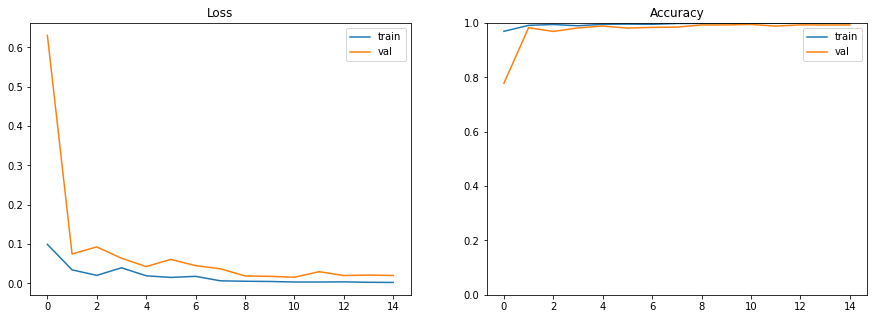

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History.history['loss'], label= 'train')
ax[0].plot(History.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].plot(History.history['accuracy'], label= 'train')
ax[1].plot(History.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0, 1])
ax[1].legend()

### Resnet models


#### Model Resnet 50v2

ResNet là kiến trúc được sử dụng phổ biến nhất ở thời điểm hiện tại. ResNet cũng là kiến trúc sớm nhất áp dụng batch normalization. 

Các kết nối tắt (skip connection) giúp giữ thông tin không bị mất bằng cách kết nối từ layer sớm trước đó tới layer phía sau và bỏ qua một vài layers trung gian. Trong các kiến trúc base network CNN của các mạng YOLOv2, YOLOv3 và gần đây là YOLOv4 bạn sẽ thường xuyên thấy các kết nối tắt được áp dụng.

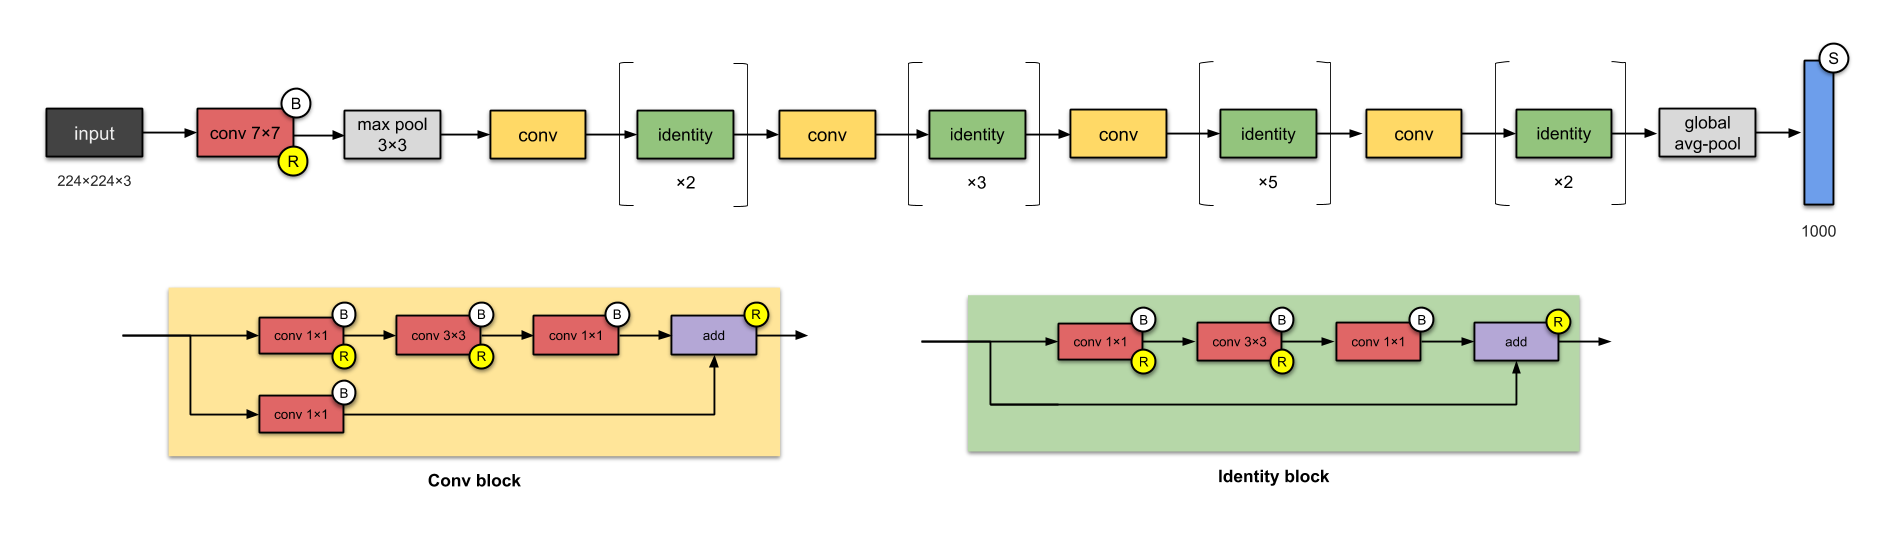

In [ ]:
_resnet50= tf.keras.applications.ResNet50V2(include_top=False,
                                            input_shape=(160, 160, 3),
                                            pooling='avg')
_resnet50.summary()

94683136/94668760 [==============================] - 2s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
________________________

In [ ]:
_resnet50.trainable = True
set_train = False
for layer in _resnet50.layers:
  if layer.name== 'conv5_block1_preact_bn':
    set_train = True
  if set_train:
    layer.trainable = True
  else:
    layer.trainable = False
  

In [ ]:
resnet50_model = Sequential()
resnet50_model.add(INPUT_LAYER)
resnet50_model.add(_resnet50)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(512, activation='relu'))
resnet50_model.add(Dropout(0.2))
resnet50_model.add(Dense(128, activation='relu'))
resnet50_model.add(Dropout(0.2))
resnet50_model.add(Dense(3, activation='softmax'))

resnet50_model.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(lr= 0.0005), metrics=['accuracy'])
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
History = resnet50_model.fit(train_data,
                   validation_data= val_data,
                   epochs= 20, 
                   callbacks= CALLBACKS)

Epoch 1/20
688/688 [==============================] - 453s 605ms/step - loss: 0.0435 - accuracy: 0.9872 - val_loss: 0.0550 - val_accuracy: 0.9869
Epoch 2/20
688/688 [==============================] - 409s 594ms/step - loss: 0.0143 - accuracy: 0.9959 - val_loss: 0.6491 - val_accuracy: 0.9091
Epoch 3/20
688/688 [==============================] - 404s 587ms/step - loss: 0.0105 - accuracy: 0.9973 - val_loss: 0.0675 - val_accuracy: 0.9863
Epoch 4/20
688/688 [==============================] - 403s 585ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.1091 - val_accuracy: 0.9688
Epoch 5/20
688/688 [==============================] - 401s 582ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.1231 - val_accuracy: 0.9644
Epoch 6/20
688/688 [==============================] - 405s 588ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0228 - val_accuracy: 0.9954
Epoch 7/20
688/688 [==============================] - 409s 595ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0839 -

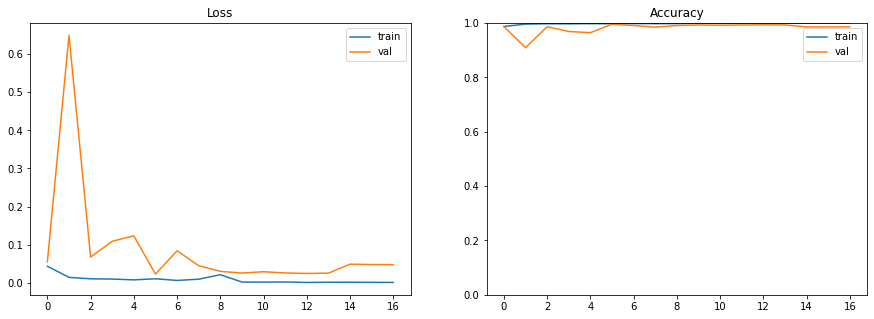

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Loss')
ax[0].plot(History.history['loss'], label= 'train')
ax[0].plot(History.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].plot(History.history['accuracy'], label= 'train')
ax[1].plot(History.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0,1])
ax[1].legend()

#### Wide Resnet 45_2

In [ ]:
def _conv(input_layer, filter_num, kernel_size= (3,3), strides = (1,1), padding='same'):
  x = Conv2D(filter_num,
              kernel_size= kernel_size,
              strides = strides,
              padding= padding,
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.0005) )(input_layer) 
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  return x

In [ ]:
def resnet_block(input_layer, filter_num, strides, num_blocks, dropout_rate= 0.1):

  x_residual = Conv2D(filter_num,
              kernel_size= 1,
              strides= strides,
              padding='same')(input_layer)
  

  x_main = Conv2D(filter_num,
              kernel_size= 3,
              strides= strides,
              padding='same' )(input_layer)

  x_main = BatchNormalization(axis=-1)(x_main)  
  x_main = Activation('relu')(x_main)
  x_main = SpatialDropout2D(rate= dropout_rate)(x_main)
  x_main = Conv2D(filter_num,
              kernel_size= 3,              
              padding='same' )(x_main)

  x_out = Add()([x_main, x_residual])

  for block in range(num_blocks-1):
    x_main = BatchNormalization(axis=-1)(x_out)  
    x_main = Activation('relu')(x_main)
    x_main = Conv2D(filter_num,
              kernel_size= 3,             
              padding='same' )(x_main)

    x_main = SpatialDropout2D(rate= dropout_rate)(x_main)
    x_main = BatchNormalization(axis=-1)(x_main)
    x_main = Activation('relu')(x_main)

    x_main = Conv2D(filter_num,
              kernel_size= 3,              
              padding='same' )(x_main)
    x_out = Add()([x_main, x_out])

  x = BatchNormalization(axis=-1)(x_out)
  x = Activation('relu')(x)
  return x

In [ ]:
def resnet_out(input_layer, n_classes):

  _dim1 = input_layer.shape[1]
  _dim2 = input_layer.shape[2]
  assert _dim1 == _dim2, 'Input shape must be square'

  x = AveragePooling2D(pool_size= _dim1)(input_layer)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.2)(x)

  x = Dense(n_classes, activation='softmax')(x)

  return x

In [ ]:
def build_WRNs(num_convs=45, k_factor=2, drop_rate=0.1, n_classes=10):

  num_miniblocks = int(math.ceil((num_convs - 5)/9))
  input_layer = INPUT_LAYER
  
  # input block ('conv1')
  x = _conv(input_layer, filter_num= 32, strides=2)

  # ('conv2' group )
  x = resnet_block(input_layer=x, 
                     filter_num=16*k_factor, 
                     num_blocks=num_miniblocks, 
                     strides=2,
                     dropout_rate=drop_rate)

  # ('conv3' group)
  x = resnet_block(input_layer=x, 
                     filter_num=32*k_factor, 
                     num_blocks= num_miniblocks, 
                     strides= 2,
                     dropout_rate=drop_rate)

  # ('conv4' group )
  x = resnet_block(input_layer=x, 
                     filter_num=64*k_factor, 
                     num_blocks= num_miniblocks, 
                     strides=2,
                     dropout_rate=drop_rate)
  # ('conv5' group )
  x = resnet_block(input_layer=x, 
                     filter_num=128*k_factor, 
                     num_blocks= num_miniblocks, 
                     strides=2,
                     dropout_rate=drop_rate)
  # output block 
  x = resnet_out(x, n_classes)
    
    # assemble
  model = Model(inputs=input_layer, outputs= x ,name= f"WRNS_v1{num_convs}_{k_factor}")
    
  return model

In [ ]:
CALLBACKS = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience= 2), # reduce learning rate
    tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience= 4, verbose= 1),  #early stop
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/pre_train_models/WRNs{epoch:02d}.ckpt', save_weights_only=True)
]

In [ ]:
wrns_45_2_model = build_WRNs(drop_rate= 0.2, n_classes= 3)
wrns_45_2_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

wrns_45_2_model.summary()

Model: "WRNS_v145_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_854 (Conv2D)             (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_849 (BatchN (None, 80, 80, 32)   128         conv2d_854[0][0]                 
__________________________________________________________________________________________________
activation_849 (Activation)     (None, 80, 80, 32)   0           batch_normalization_849[0][0]    
________________________________________________________________________________________

In [ ]:
History10 = wrns_45_2_model.fit(train_data,
                   epochs= 20, 
                   validation_data= val_data, 
                   callbacks= CALLBACKS
                   )

Epoch 1/20
688/688 [==============================] - 370s 538ms/step - loss: 0.1883 - accuracy: 0.9489 - val_loss: 0.2313 - val_accuracy: 0.9331
Epoch 2/20
688/688 [==============================] - 369s 536ms/step - loss: 0.1183 - accuracy: 0.9712 - val_loss: 0.2058 - val_accuracy: 0.9495
Epoch 3/20
688/688 [==============================] - 370s 538ms/step - loss: 0.0928 - accuracy: 0.9788 - val_loss: 0.0954 - val_accuracy: 0.9776
Epoch 4/20
688/688 [==============================] - 371s 539ms/step - loss: 0.0820 - accuracy: 0.9813 - val_loss: 0.1133 - val_accuracy: 0.9761
Epoch 5/20
688/688 [==============================] - 369s 536ms/step - loss: 0.0738 - accuracy: 0.9840 - val_loss: 0.1711 - val_accuracy: 0.9522
Epoch 6/20
688/688 [==============================] - 372s 540ms/step - loss: 0.0625 - accuracy: 0.9869 - val_loss: 0.0749 - val_accuracy: 0.9795
Epoch 7/20
688/688 [==============================] - 370s 538ms/step - loss: 0.0608 - accuracy: 0.9868 - val_loss: 0.1077 -

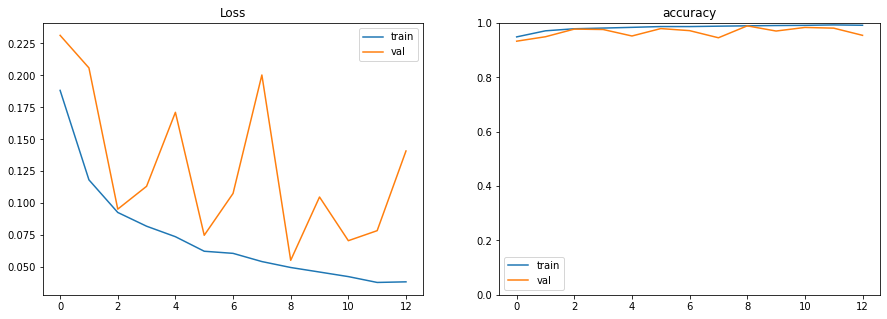

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(History10.history['loss'], label= 'train')
ax[0].plot(History10.history['val_loss'], label= 'val')
ax[0].legend()

ax[1].set_title('accuracy')
ax[1].plot(History10.history['accuracy'], label= 'train')
ax[1].plot(History10.history['val_accuracy'], label= 'val')
ax[1].set_ylim([0,1])
ax[1].legend()

In [ ]:
wrns_45_2_model.evaluate(test_data)

138/138 [==============================] - 15s 105ms/step - loss: 0.1573 - accuracy: 0.9511


[0.15731580555438995, 0.9510585069656372]

In [ ]:
wrns_45_2_model.save('/content/drive/MyDrive/pre_train_models/Wrns.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
m = load_model('/content/drive/MyDrive/pre_train_models/Wrns_45_2.h5')

In [ ]:
if not os.path.exists('./content/extendFM/'):
  !unrar x   "/content/drive/MyDrive/extendFM.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/extendFM/face_with_mask_correct/767.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/768.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/769.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/77.jpg               83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/770.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/771.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/772.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/773.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/774.jpg              83%  OK 
Extracting  /content/extendFM/face_with_mask_correct/775.jpg              83%  OK 
Extracting  /content/extendFM

In [ ]:
 train_ext = train_gen.flow_from_directory('/content/extendFM',
                                        target_size= (IMG_HEIGHT, IMG_WIDTH),
                                        class_mode= 'categorical',
                                        batch_size = BATCH_SIZE,                                        
                                                                        
                                        )

Found 14697 images belonging to 3 classes.


In [ ]:
m.fit( train_ext, 
      epochs=20, 
      validation_data= val_data,
      callbacks= CALLBACKS
      )

Epoch 1/20
230/230 [==============================] - 184s 640ms/step - loss: 0.1733 - accuracy: 0.9474 - val_loss: 0.0767 - val_accuracy: 0.9795
Epoch 2/20
230/230 [==============================] - 146s 634ms/step - loss: 0.1146 - accuracy: 0.9672 - val_loss: 0.0763 - val_accuracy: 0.9781
Epoch 3/20
230/230 [==============================] - 146s 634ms/step - loss: 0.0995 - accuracy: 0.9707 - val_loss: 0.0623 - val_accuracy: 0.9851
Epoch 4/20
230/230 [==============================] - 146s 635ms/step - loss: 0.0873 - accuracy: 0.9741 - val_loss: 1.6823 - val_accuracy: 0.5723
Epoch 5/20
230/230 [==============================] - 146s 637ms/step - loss: 0.0781 - accuracy: 0.9782 - val_loss: 0.1662 - val_accuracy: 0.9430

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/20
230/230 [==============================] - 146s 636ms/step - loss: 0.0639 - accuracy: 0.9831 - val_loss: 0.1820 - val_accuracy: 0.9297
Epoch 7/20
230/230 [======================

In [ ]:
m.evaluate(test_data)

138/138 [==============================] - 21s 154ms/step - loss: 0.0696 - accuracy: 0.9809


[0.06960432231426239, 0.9808786511421204]

In [ ]:
m.save('/content/drive/MyDrive/pre_train_models/Wrns.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
img = test_data[0][0][:30]
model = load_model('/content/drive/MyDrive/pre_train_models/Wrns.h5')

In [ ]:
m.evaluate(test_data)

138/138 [==============================] - 23s 147ms/step - loss: 0.0696 - accuracy: 0.9809


[0.06960435211658478, 0.9808786511421204]

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_data, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_data.classes, y_pred_bool))

138/138 [==============================] - 21s 152ms/step
              precision    recall  f1-score   support

           0       0.40      0.38      0.39      3429
           1       0.40      0.41      0.41      3434
           2       0.23      0.24      0.23      1923

    accuracy                           0.36      8786
   macro avg       0.34      0.34      0.34      8786
weighted avg       0.36      0.36      0.36      8786



### Test trên dataset

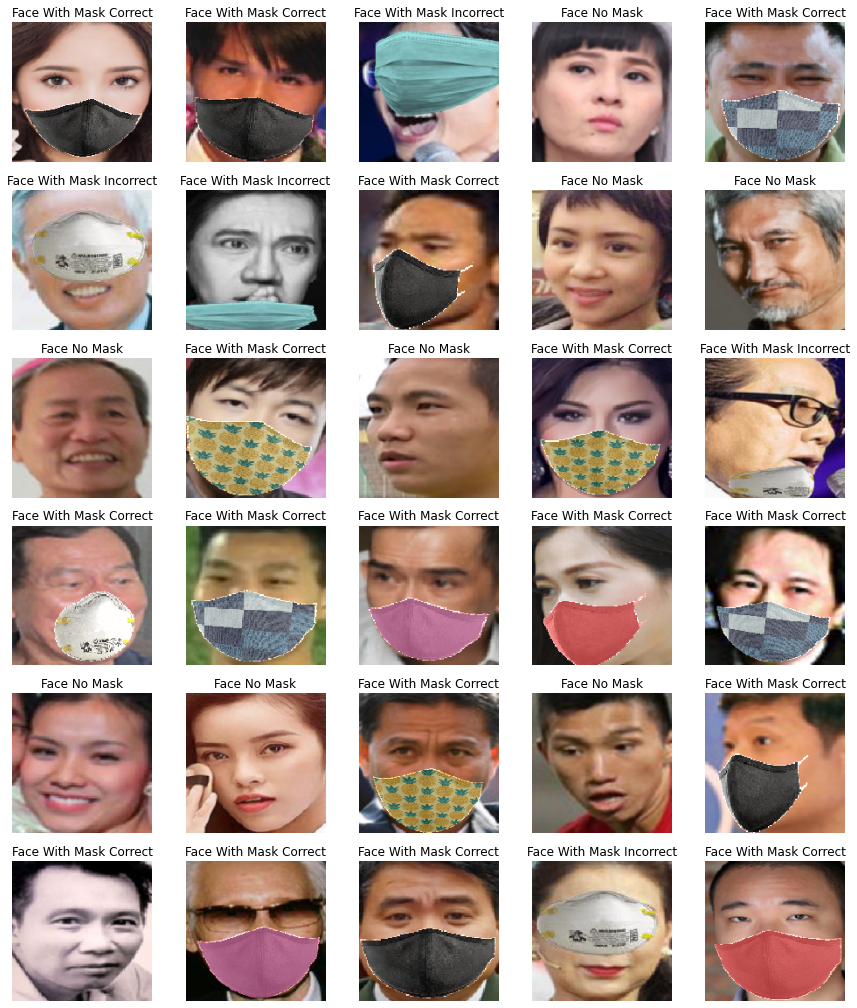

In [ ]:
pred = m.predict(test_data[0][0][:30])
display_images(img, pred)

### Test ảnh thực

In [ ]:
import cv2

from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

prototxtPath = r'/content/drive/MyDrive/pre_train_models/deploy.prototxt'
weightsPath = r'/content/drive/MyDrive/pre_train_models/res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNet(prototxtPath, weightsPath)
mask_model = load_model('/content/drive/MyDrive/pre_train_models/Wrns.h5')

In [ ]:
def get_class(I_classes):
  _class = np.argmax(I_classes)
  return CLASSES_NAMES.get(_class)

In [ ]:
import numpy as np
def mask_detection(img_path):
  image = cv2.imread(img_path)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1.0, (h, w),
		(104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  for i in range(0, detections.shape[2]):
    ## get detection probability
    confidence = detections[0, 0, i, 2]
    if confidence > 0.1:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      print(confidence*100)
    ## box normalizer
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    ## get face
      face = image[startY:endY, startX:endX]
      if face.any():
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (160, 160))
        face = img_to_array(face)/255
        face = np.expand_dims(face, axis=0)
        probs = mask_model.predict(face)
        cv2.rectangle(image, (startX, startY), (endX, endY), (0,255,0), 2)
        cv2.putText(image, get_class(probs[0]), (startX, startY - 10),	cv2.FONT_HERSHEY_SIMPLEX, 0.45,(0,0,255), 2)
  cv2_imshow(image)

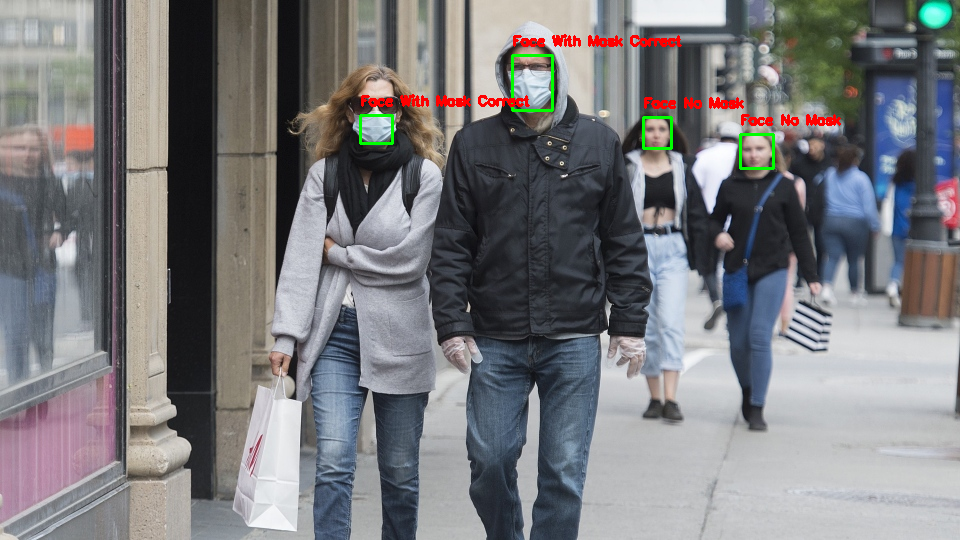

In [ ]:
mask_detection("/content/image_2.jpg")

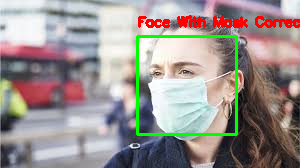

In [ ]:
mask_detection("/content/image_3.jpg")

14.63036984205246
12.578234076499939
12.462320923805237
12.437038868665695
12.231971323490143
11.938122659921646
11.527813971042633
11.413954198360443
11.391238868236542
11.295783519744873
11.162686347961426
10.954054445028305
10.666188597679138
10.602982342243195
10.496263951063156
10.441628098487854
10.266240686178207
10.236480832099915
10.217268019914627
10.207415372133255
10.142524540424347


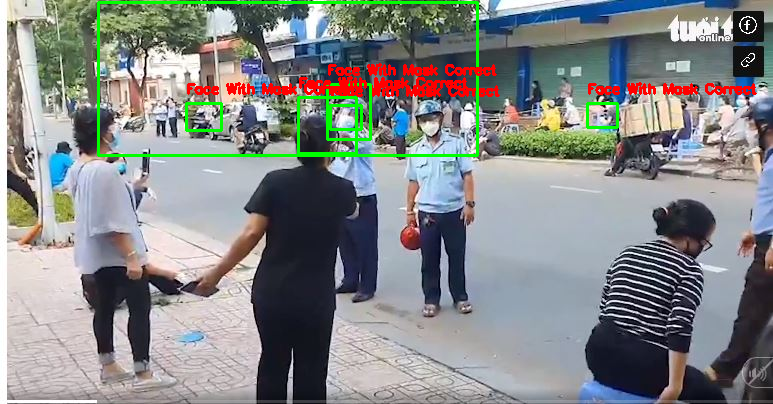

In [ ]:
mask_detection("/content/Capture.JPG")